In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import dataretrieval as nwis
from hydroeval import evaluator, nse
from tqdm import tqdm
import datetime as dt
import geopandas
import xarray as xr

In [34]:
i = 163
pnwNP = pd.read_csv("../data/pnwNP_StatsLocationsSSwNames.csv")
pnwNP['comid'][i]

24383455.0

In [22]:
df = pd.read_csv('../data/pnwNP_modeledData/'+str(pnwNP['gage'][i])+".csv")
df['time'] = pd.to_datetime(df['time'])
df['water_year'] = df.time.dt.year.where(df.time.dt.month < 10, df.time.dt.year + 1)
df

,Unnamed: 0,streamflow_VIC,time,streamflow_PRMS,streamflow_NWM2d0,streamflow_NWM2d1,streamflow_NWIS,gage,water_year
0,0,2.881029,1950-01-01,4.524933,NaN,NaN,NaN,12447383,1950
1,1,4.845531,1950-01-02,7.295784,NaN,NaN,NaN,12447383,1950
2,2,5.303875,1950-01-03,7.620400,NaN,NaN,NaN,12447383,1950
3,3,5.325573,1950-01-04,7.322917,NaN,NaN,NaN,12447383,1950
4,4,5.266046,1950-01-05,6.951945,NaN,NaN,NaN,12447383,1950
...,...,...,...,...,...,...,...,...,...
25928,25928,NaN,2020-12-27,NaN,NaN,8.955000,3.256437,12447383,2021
25929,25929,NaN,2020-12-28,NaN,NaN,8.840833,3.256437,12447383,2021
25930,25930,NaN,2020-12-29,NaN,NaN,8.727083,3.171487,12447383,2021
25931,25931,NaN,2020-12-30,NaN,NaN,8.615416,3.086536,12447383,2021


In [11]:
cfs_2_cms = 0.0283168466

In [27]:
prms = pd.read_csv("../data/zz_tests/historical_livneh_PRMS_P1-METGO-streamflow-1.0.csv",comment='#')
prms['streamflow'] = prms['streamflow']*cfs_2_cms

vic = pd.read_csv("../data/zz_tests/historical_livneh_VIC_P1-METGO-streamflow-1.0.csv",comment='#')
vic['streamflow'] = vic['streamflow']*cfs_2_cms

vic.columns = ['time','VIC_bygage']
vic['time'] = pd.to_datetime(vic['time'])

In [101]:
### Pull out sites
shp = geopandas.read_file("../data/VIC_UW/shapefiles/columbia_seg.shp")
# shp = pnwNP.merge(shp,how = 'left',left_on='comid',right_on='POI_ID')

## Open modeled datasets (VIC and PRMS) for just reach ID and runoff
pnwVIC = xr.open_mfdataset('../data/VIC_UW/vic_historical_first_route_all.nc')[['reachID','IRFroutedRunoff']]


pnwPRMS = xr.open_mfdataset('../data/VIC_UW/prms_historical_first_route_all.nc')[['reachID','IRFroutedRunoff']]

In [100]:
shp.iloc[i]
# shp = geopandas.read_file("../data/VIC_UW/shapefiles/columbia_seg.shp")
# shp

Unnamed: 0                                                     163
site_no                                                   12447383
station_nm           METHOW RIVER ABOVE GOAT CREEK NEAR MAZAMA, WA
Unnamed: 0.1                                                   163
gage                                                      12447383
dec_lat                                                   48.57425
dec_long                                               -120.385861
numZero                                                       1649
numOne                                                        1722
startDate                                               1991-04-21
endDate                                                 2020-12-31
comid                                                   24383455.0
numObs                                                       10847
propZero                                                  0.152024
propOne                                                   0.15

In [111]:
## Get Vic data
# VIC = pnwVIC.where(pnwVIC['reachID']==shp['seg_id'][i],drop=True).to_dataframe()
VIC = pnwVIC.where(pnwVIC['reachID']==5131,drop=True).to_dataframe()
VIC = VIC.drop(['reachID'],axis=1)
VIC= VIC.droplevel('seg')
VIC['time'] = pd.to_datetime(VIC.index,)
VIC['time'] = VIC['time'].dt.tz_localize(None)
VIC = VIC.reset_index(drop=True)
VIC.columns = ["streamflow_VIC","time"]



# ## Get PRMS data
# PRMS = pnwPRMS.where(pnwPRMS['reachID']==shp['seg_id'][i],drop=True).to_dataframe()
# PRMS = PRMS.drop(['reachID'],axis=1)
# PRMS= PRMS.droplevel('seg')
# PRMS['time'] = pd.to_datetime(PRMS.index,)
# PRMS['time'] = PRMS['time'].dt.tz_localize(None)
# PRMS = PRMS.reset_index(drop=True)
# PRMS.columns = ["streamflow_PRMS","time"]

In [112]:
VIC

,streamflow_VIC,time
0,2.881029,1950-01-01
1,4.845531,1950-01-02
2,5.303875,1950-01-03
3,5.325573,1950-01-04
4,5.266046,1950-01-05
...,...,...
22640,8.295341,2011-12-27
22641,8.183731,2011-12-28
22642,8.082645,2011-12-29
22643,7.983723,2011-12-30


In [102]:
shp[shp["seg_id"] == 5119]

,DrainID,Region,tosegment2,tosegment,seg_id,seg_id2,POI_ID,TOCOMID2,To_POI_ID,ToFTYPE,...,start_y,TopElev,start_lon,start_lat,end_x,end_y,BotElev,end_lon,end_lat,geometry
5774,0,17,17005118,5118,5119,17005119,24383027.0,24383025,24383025,StreamRiver,...,3069870.0,637.0,-120.17514,48.57766,-1.786889e+06,3.059175e+06,531.0,-120.18313,48.47581,"LINESTRING (-1783490.166 3069872.088, -1783508..."


In [124]:
datMain = pd.merge(df,vic, on='time',how='outer')
datMain

,Unnamed: 0,streamflow_VIC,time,streamflow_PRMS,streamflow_NWM2d0,streamflow_NWM2d1,streamflow_NWIS,gage,water_year,VIC_bygage
0,0,2.881029,1950-01-01,4.524933,NaN,NaN,NaN,12447383,1950,6.224836
1,1,4.845531,1950-01-02,7.295784,NaN,NaN,NaN,12447383,1950,6.815072
2,2,5.303875,1950-01-03,7.620400,NaN,NaN,NaN,12447383,1950,6.768661
3,3,5.325573,1950-01-04,7.322917,NaN,NaN,NaN,12447383,1950,6.716643
4,4,5.266046,1950-01-05,6.951945,NaN,NaN,NaN,12447383,1950,6.665134
...,...,...,...,...,...,...,...,...,...,...
25928,25928,NaN,2020-12-27,NaN,NaN,8.955000,3.256437,12447383,2021,NaN
25929,25929,NaN,2020-12-28,NaN,NaN,8.840833,3.256437,12447383,2021,NaN
25930,25930,NaN,2020-12-29,NaN,NaN,8.727083,3.171487,12447383,2021,NaN
25931,25931,NaN,2020-12-30,NaN,NaN,8.615416,3.086536,12447383,2021,NaN


In [143]:
tt = datMain[['time','streamflow_NWIS','streamflow_VIC','VIC_bygage','streamflow_NWM2d1']]
# tt["diff"] = tt['streamflow_VIC']-tt['VIC_bygage']

[]

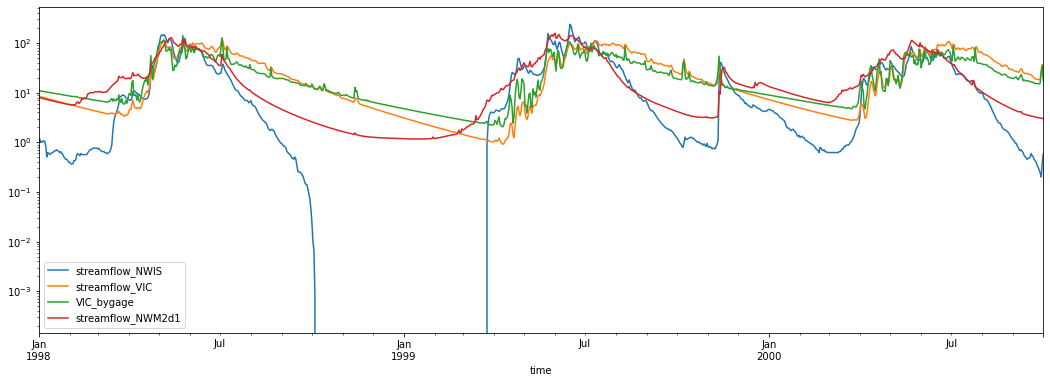

In [144]:
ax = tt.plot(x='time',figsize=(18,6))
ax.set_xlim("1998-01-01",'2000-10-01')
ax.semilogy()

In [142]:
tt.describe()

,streamflow_NWIS,streamflow_VIC,VIC_bygage,diff
count,10483.000000,22645.000000,22645.000000,22645.000000
mean,15.525530,23.808985,19.186976,4.622009
std,28.260891,28.291300,20.706532,10.987509
min,0.000000,0.613616,0.938788,-64.573518
25%,0.368119,3.504441,5.044646,-1.383902
50%,2.758061,10.316236,10.782291,-0.399702
75%,15.602582,35.523056,26.051442,8.329546
max,239.560522,196.297790,235.110388,74.354041
